In [1]:
import os
from glob import glob
import random
import cv2
from PIL import Image
import numpy as np
import copy
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset, DataLoader
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import make_grid
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import albumentations as A
'''deepmets'''
from deepmets.backbone import *
from deepmets.head import *
'''UTNet'''
from UTNet.unet_utils import up_block, down_block
from UTNet.conv_trans_utils import *
from UTNet.utnet import UTNet, UTNet_Encoderonly
'''Efficient-Unet'''
from EfficientUnet.efficientunet import *

## Prostate Dataset

In [2]:
class Dataset_Prostate(Dataset):
    """ Prostate Dataset """
    def __init__(self, paths, transform=None):
        self.transform = transform
        self.imgs = paths
            
        print("total {} slices".format(len(self.imgs)))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        
        raw_file = self.imgs[idx]
        raw_inp = np.load(raw_file)
        
        image_patch = raw_inp[..., 0:3] #(384, 384, 3)
        mask_patch = raw_inp[..., 3:] #(384, 384, 1)
        mask_patch = np.where(mask_patch>=1, 1, 0) #set 
        image_patches = image_patch.copy()
        
        if self.transform is not None:
            aug = self.transform(image=image_patches, mask=mask_patch)
            image = aug['image']
            mask = aug['mask']
        
        #transpose and shift to 0-1
        image = image.transpose(2, 0, 1)/255
        image = torch.from_numpy(image).type(torch.float32)
        image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image)
        mask = mask.transpose(2, 0, 1) #no need to divide by 255 again
        #to torch tensor
        mask = torch.from_numpy(mask).type(torch.float32)
        
        sample = {"image": image, "label": mask}
        return sample

In [3]:
train_pro_tfm = A.Compose([
    A.Resize(width=384, height=384, p=1.0),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.HorizontalFlip(p=0.5),
])

eval_pro_tfm = A.Compose([
    A.Resize(width=384, height=384, p=1.0)
])

## gamma selection

In [4]:
def gam_logit_select(points, pred, label, rho=0.5):
    #points shape: (batch_size, 1, 256, 256)
    eps = 1e-5
    #points, pred, label = points.data.cpu().numpy(), pred.data.cpu().numpy(), label.data.cpu().numpy()
    '''get median position index'''
    slice_points = torch.mean(points.reshape((points.shape[0],-1)), axis=-1) #(16, 256x256)
    med_idx = torch.argsort(slice_points)[len(slice_points)//2] #median index
    #print(pred.shape, med_idx)
    '''compute pos and neg'''
    logit = torch.sigmoid(pred[med_idx]) #compute logit for median
    '''compute positive and negative'''
    #pos = (1-rho)*torch.log(logit) #(rho-1)*(-1)
    pos = (rho-1)/(torch.log(logit)+eps)
    #neg = -(1-rho)*torch.log(1+torch.exp(pred[med_idx]))#(rho-1)
    neg = (1-rho)/(torch.log(1+torch.exp(pred[med_idx]))+eps)
    
    gamma = torch.mean(label[med_idx]*pos+(1-label[med_idx])*neg) #argmax to argmin, add minus
    gam_clip = torch.clamp(gamma, 1e-4, 1).data.cpu().numpy()
    return gam_clip

## Loss function

In [5]:
def dice_coef_metric(pred, label):
    intersection = 2.0 * (pred * label).sum()
    union = pred.sum() + label.sum()
    if (pred.sum() == 0) and (label.sum() == 0):
        return 1.
    return intersection / union

def iou_metric(pred, label):
    intersection = np.sum(pred * label)
    union = np.sum(pred) + np.sum(label) - intersection
    if (np.sum(pred) == 0) and (np.sum(label) == 0):
        return 1 
    return intersection / union

def gamma_dice_loss(pred, label, gamma=1e-4):
    '''
    gamma selection: positive number, min: 1e-6
    '''
    pos = torch.sigmoid((1+gamma)*pred)
    neg = 1 - pos
    power = gamma/(1+gamma)
    #gamma_loss = (1/gamma)*torch.mean(label*(1-(pos**power)) + (1-label)*(1-(neg**power)))
    score = label*((1-(pos**power))/gamma) + (1-label)*((1-(neg**power))/gamma)
    '''gamma selection for this batch, used for computing mean gamma for next FL round'''
    gam_update = gam_logit_select(score, pred, label)
    gamma_loss = torch.mean(score)
    dice_loss = dice_coef_loss(pred, label)
    tot_loss = gamma_loss + dice_loss
    return tot_loss, gam_update

def dice_coef_loss(pred, label):
    smooth = 1.0
    intersection = 2.0 * (pred * label).sum() + smooth
    union = pred.sum() + label.sum() + smooth
    return 1 - (intersection / union)

def bce_dice_loss(pred, label):
    dice_loss = dice_coef_loss(pred, label)
    bce_loss = nn.BCELoss()(pred, label)
    #bce_loss = nn.BCEWithLogitsLoss()(pred, label)
    return dice_loss + bce_loss

## Configuration

In [6]:
config = {
    'n_epochs': 150, #50
    'batch_size': 64, #64
    'learning_rate': 5e-4, #5e-4, #1e-3
    'early_stop': 150,
    'model_name': 'effunet', #change model name: 'unet', 'resnext_unet', 'deepmets'
    'loss': gamma_dice_loss, #change loss function
    'loss_name': 'gamma_dice_loss', #change loss function name for saving file
    'gamma': 1e-4, #gamma>0, gamma_dice_loss, gamma=0, bce_dice_loss
    'mislabel_rate': 0, #0, 0.4, 0.6
    'seed': 1000,
    'n_worker': 4, #if not enough memory or model is large, set to 0 
}
save_path = 'pros-mri-'+config['model_name']+'_'+config['loss_name']+'_cln_0425.pth'
print('save_path:', save_path)

save_path: pros-mri-effunet_gamma_dice_loss_cln_0425.pth


## Dataloader

In [7]:
image_list = []
client_num = 6
client_name = [f'client{cl+1}' for cl in range(client_num)]
for client_idx in range(client_num):
    #Prostate
    image_list += glob('../Shared/Pin-Han/Prostate/{}/data_npy/*'.format(client_name[client_idx]))
    
#train test split
train, test = train_test_split(image_list, test_size=0.1, random_state=config['seed'])
train, val = train_test_split(train, test_size=0.1, random_state=config['seed'])
#we can perform augmentation
train_set = Dataset_Prostate(train, train_pro_tfm)
val_set = Dataset_Prostate(val, eval_pro_tfm)
test_set = Dataset_Prostate(test, eval_pro_tfm)

#dataloader
train_loader = DataLoader(train_set, batch_size=config['batch_size'], shuffle=True,  num_workers=config['n_worker'], pin_memory=True)
val_loader = DataLoader(val_set, batch_size=config['batch_size'], shuffle=False,  num_workers=config['n_worker'], pin_memory=True)
test_loader = DataLoader(test_set, batch_size=config['batch_size'], shuffle=False,  num_workers=config['n_worker'], pin_memory=True)

total 3148 slices
total 350 slices
total 389 slices


In [8]:
def ellipsis_mask(mask):
    #np.random.seed(1)
    rands = np.random.randint(1, 5, (2,))
    center = np.random.randint(-5, 5, (2,))
    
    x0 = center[0]; a = rands[0]  # x center, half width                                       
    y0 = center[1]; b = rands[1]  # y center, half height
    x = np.linspace(-10, 10, mask.shape[-1])  # x values of interest
    y = np.linspace(-10, 10, mask.shape[-1])[:,None]  # y values of interest, as a "column" array
    ellipse = ((x-x0)/a)**2 + ((y-y0)/b)**2 <= 1  # True for points inside the ellipse
    ellipse = ellipse.astype('int').reshape(mask.shape)
    return ellipse

In [9]:
def mislabeling(masklist, epc):
    '''set seed'''
    random.seed(100+epc)
    np.random.seed(100+epc)
    
    '''convert to numpy'''
    masklist = masklist.data.cpu().numpy()
    '''split idx for zoom in or out'''
    idx = masklist.shape[0] // 2
    mismask_full = np.zeros_like(masklist)
    
    for i, mask in enumerate(masklist):
        if i <= idx:
            '''affine transformation'''
            mismask = A.Affine(scale=0.5, rotate=180, p=1)(image=mask)['image']
        else:
            '''ellipsis mislabeling'''
            mismask = ellipsis_mask(mask)
        mismask_full[i] = mismask
    return torch.from_numpy(mismask_full)

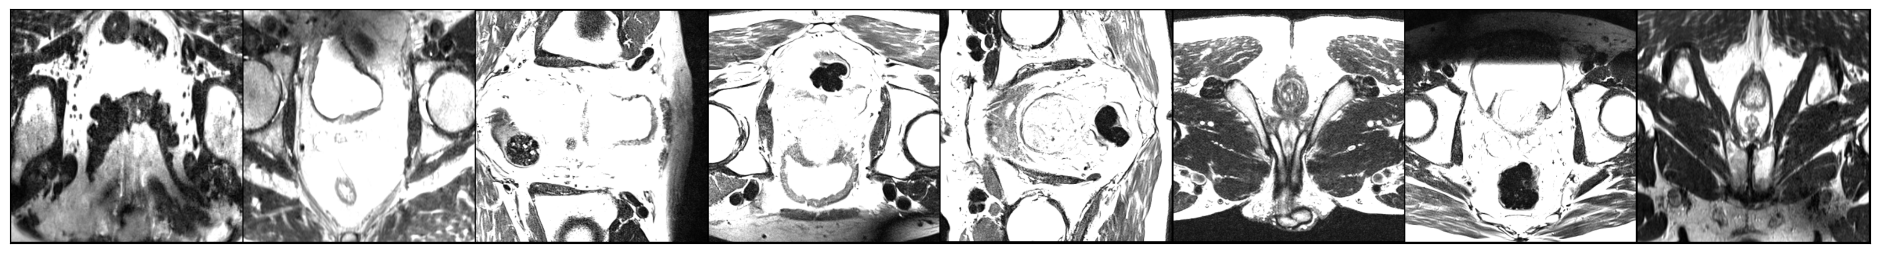

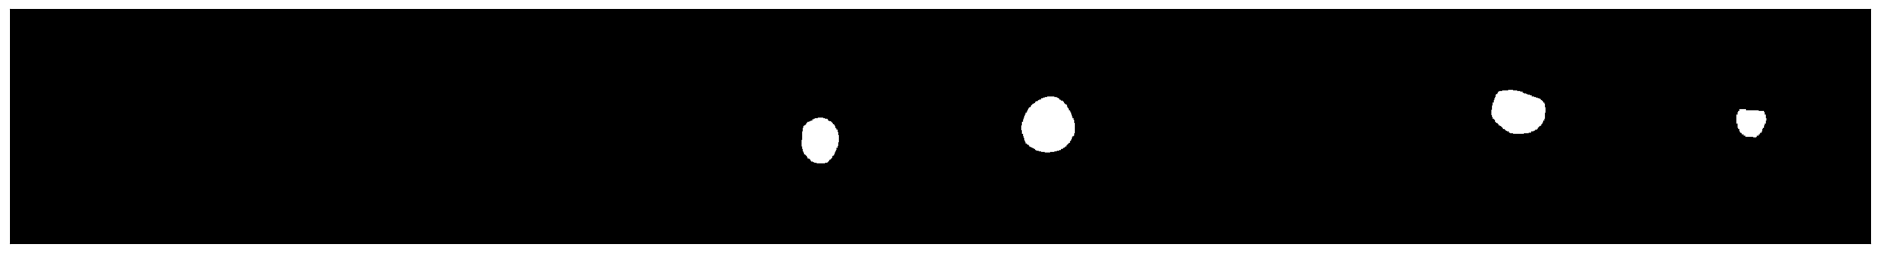

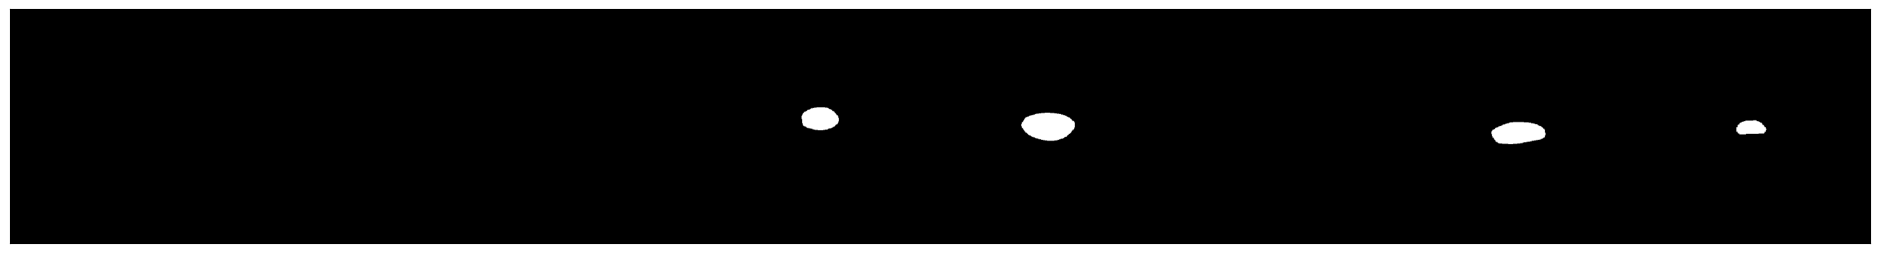

In [10]:
def denormalize(images):
    means = torch.tensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1)
    stds = torch.tensor([0.5, 0.5, 0.5]).reshape(1, 3, 1, 1)
    #means = torch.tensor([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
    #stds = torch.tensor([0.229, 0.224, 0.225]).reshape(1, 3, 1, 1)
    return images * stds + means

def show_misbatch(dl):
    for batch in dl:
        fig1, ax1 = plt.subplots(figsize=(24, 24))
        ax1.set_xticks([]); ax1.set_yticks([])
        #print(images.shape, masks.shape)
        images = batch['image'] #(32, 3, 384, 384)
        masks = batch['label']
        denorm_images = denormalize(images)
        ax1.imshow(make_grid(denorm_images[13:21], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        
        fig2, ax2 = plt.subplots(figsize=(24, 24))
        ax2.set_xticks([]); ax2.set_yticks([])
        ax2.imshow(make_grid(masks[13:21], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        fig3, ax3 = plt.subplots(figsize=(24, 24))
        ax3.set_xticks([]); ax3.set_yticks([])
        mismasks = mislabeling(masks, 100)
        ax3.imshow(make_grid(mismasks[13:21], nrow=13).permute(1, 2, 0).clamp(0,1))
        
        break
show_misbatch(train_loader)

## Model

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
if config['model_name'] == 'effunet':
    model = efficientunet.get_efficientunet_b0(out_channels=1, concat_input=True, pretrained=True).to(device)

Using cuda device


## Train loop

In [12]:
def train_loop(model, loader, gamma, config):
    
    loss_func, loss_name, mislabel_rate = config['loss'], config['loss_name'], config['mislabel_rate']
    train_losses = []
    train_pred_out = []
    train_mask_out = []
    gam_update_full = []
    
    model.train()
#   for i, (image, mask) in enumerate(tqdm(loader)):
    for i, batch in tqdm(enumerate(loader), total=len(loader)):
        image = batch['image'].to(device)
        mask = batch['label'].to(device)
        
        '''add mislabel'''
        if mislabel_rate > 0:
            mis_idx = round(mislabel_rate*mask.shape[0])
            mask[:mis_idx] = mislabeling(mask[:mis_idx], i).to(device)
        
        outputs = model(image)
        #outputs = outputs['x_final']
        out_cut = np.copy(outputs.detach().cpu().numpy())
        #out_cut = np.copy(outputs.data.cpu().numpy())
        #append score and info
        train_pred_out.append(out_cut)
        train_mask_out.append(mask.data.cpu().numpy())
        
        '''gamma value'''
        if loss_name == 'gamma_dice_loss':
            #gamma = 0.5
            loss, gam_update = loss_func(outputs, mask, gamma)
            gam_update_full.append(gam_update) #.data.cpu().numpy()
        else:
            loss = loss_func(outputs, mask)
        
        
        train_losses.append(loss.item())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    
    '''update auto gamma selection'''
    if loss_name == 'gamma_dice_loss':
        gamma = np.mean(gam_update_full)
    
    train_mean_loss = np.mean(train_losses)
    #stack full predicted masks
    train_outs = np.vstack(train_pred_out)
    train_masks = np.vstack(train_mask_out)
    
    train_outs[np.nonzero(train_outs < 0.3)] = 0.0 #thrs=0.5
    train_outs[np.nonzero(train_outs >= 0.3)] = 1.0
    
    train_mean_dice = dice_coef_metric(train_outs, train_masks)
    train_mean_iou = iou_metric(train_outs, train_masks)
    
    
    return train_mean_dice, train_mean_iou, train_mean_loss, gamma

## Eval loop

In [13]:
def eval_loop(model, loader, gamma, config, run, training=True):
    
    loss_func, loss_name, mislabel_rate = config['loss'], config['loss_name'], config['mislabel_rate']
    val_losses = []
    eval_pred_out = []
    eval_mask_out = []
    
    model.eval()
    with torch.no_grad():
        for step, batch in tqdm(enumerate(loader), total=len(loader)):
            image = batch['image'].to(device)
            mask = batch['label'].to(device)
            
            '''mislabeling'''
            if (run == 'val') and (mislabel_rate > 0):
                mis_idx = round(mislabel_rate*mask.shape[0]) #compute mislabel idx for normal/mislabel split
                mask[:mis_idx] = mislabeling(mask[:mis_idx], step).to(device)
            
            
            outputs = model(image)
            #outputs = outputs['x_final']
            '''which loss function'''
            if loss_name == 'gamma_dice_loss':
                #gamma = 0.5
                loss, _ = loss_func(outputs, mask, gamma)
            else:
                loss = loss_func(outputs, mask)
            
            
            out_cut = np.copy(outputs.detach().cpu().numpy())
            '''
            out_cut[np.nonzero(out_cut < 0.3)] = 0.0
            out_cut[np.nonzero(out_cut >= 0.3)] = 1.0
            '''
            #out_cut = np.copy(outputs.data.cpu().numpy())
            
            #append score and info
            eval_pred_out.append(out_cut)
            eval_mask_out.append(mask.data.cpu().numpy())
            
            val_losses.append(loss.cpu().numpy())
            
        eval_mean_loss = np.mean(val_losses)

        
        #stack full predicted masks
        eval_outs = np.vstack(eval_pred_out)
        eval_masks = np.vstack(eval_mask_out)
        
        eval_outs[np.nonzero(eval_outs < 0.3)] = 0.0 #thrs=0.5
        eval_outs[np.nonzero(eval_outs >= 0.3)] = 1.0
        
        eval_mean_dice = dice_coef_metric(eval_outs, eval_masks)
        eval_mean_iou = iou_metric(eval_outs, eval_masks)
        
        if training:
            scheduler.step(eval_mean_dice)
        #scheduler.step()
        
    return eval_mean_dice, eval_mean_iou, eval_mean_loss

## Train model

In [14]:
def save_model(model, save_path):
    """
    Function to save the trained model to disk.
    """
    save_dir = './model_results'
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    torch.save(model.state_dict(), os.path.join(save_dir, save_path))

In [15]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, config):
    
    num_epochs, gamma, early_stop = config['n_epochs'], config['gamma'], config['early_stop'] 
    
    train_loss_history, train_dice_history, train_iou_history = [], [], []
    val_loss_history, val_dice_history, val_iou_history = [], [], []
    gamma_history = []
    
    best_iou = 0
    stale = 0
    #early_stop = 10
    for epoch in range(num_epochs):
        train_mean_dice, train_mean_iou, train_mean_loss, gamma = train_loop(model, train_loader, gamma, config)
        val_mean_dice, val_mean_iou, val_mean_loss = eval_loop(model, val_loader, gamma, config, run='val')
        print(f'gamma value in {epoch} epoch:', gamma)
        gamma_history.append(gamma)
        
        #train history
        train_dice_history.append(train_mean_dice)
        train_iou_history.append(train_mean_iou)
        train_loss_history.append(train_mean_loss)
        
        #validation history
        val_dice_history.append(val_mean_dice)
        val_iou_history.append(val_mean_iou)
        val_loss_history.append(val_mean_loss)
        print('Epoch: {}/{} |  Train Loss: {:.3f}, Val Loss: {:.3f}, Train DICE: {:.3f}, Val DICE: {:.3f}, Train IOU: {:.3f}, Val IOU: {:.3f}'.format(epoch+1, num_epochs,
                                                                                                                                            train_mean_loss,
                                                                                                                                            val_mean_loss,
                                                                                                                                            train_mean_dice,
                                                                                                                                            val_mean_dice,
                                                                                                                                            train_mean_iou,
                                                                                                                                            val_mean_iou))
        #early stop
        if val_mean_iou > best_iou:
            best_iou = val_mean_iou
            
            # Save the trained model weights.
            print(f'Save best model at {epoch+1} epoch:')
            ##############################
            ##############################
            # SAVE MODEL NAME
            save_model(model, save_path)
            ##############################
            ##############################
            stale = 0
        else:
            stale += 1
            if stale > early_stop:
                print(f"No improvment {early_stop} consecutive epochs, early stopping")
                break
        
    return train_loss_history, train_dice_history, train_iou_history,  val_loss_history, val_dice_history, val_iou_history, gamma_history

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) #U-net: 1e-3, ResNeXt: 5e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

In [17]:
save_path

'pros-mri-effunet_gamma_dice_loss_cln_0425.pth'

In [18]:
%%time
#change loss function
train_loss_history, train_dice_history, train_iou_history, val_loss_history, val_dice_history, val_iou_history, gamma_history = train_model(model, train_loader, val_loader, optimizer, scheduler, config)

100% 50/50 [00:28<00:00,  1.74it/s]
100% 6/6 [00:01<00:00,  3.53it/s]


gamma value in 0 epoch: 0.58321524
Epoch: 1/150 |  Train Loss: 1.795, Val Loss: 1.422, Train DICE: 0.058, Val DICE: 0.066, Train IOU: 0.030, Val IOU: 0.034
Save best model at 1 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.66it/s]


gamma value in 1 epoch: 0.6215038
Epoch: 2/150 |  Train Loss: 1.354, Val Loss: 1.340, Train DICE: 0.250, Val DICE: 0.418, Train IOU: 0.143, Val IOU: 0.264
Save best model at 2 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.93it/s]


gamma value in 2 epoch: 0.64871335
Epoch: 3/150 |  Train Loss: 1.286, Val Loss: 1.258, Train DICE: 0.638, Val DICE: 0.686, Train IOU: 0.469, Val IOU: 0.522
Save best model at 3 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.93it/s]


gamma value in 3 epoch: 0.66703415
Epoch: 4/150 |  Train Loss: 1.209, Val Loss: 1.174, Train DICE: 0.777, Val DICE: 0.761, Train IOU: 0.635, Val IOU: 0.614
Save best model at 4 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.93it/s]


gamma value in 4 epoch: 0.6852904
Epoch: 5/150 |  Train Loss: 1.114, Val Loss: 1.082, Train DICE: 0.801, Val DICE: 0.746, Train IOU: 0.668, Val IOU: 0.594


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.51it/s]


gamma value in 5 epoch: 0.7004005
Epoch: 6/150 |  Train Loss: 0.994, Val Loss: 0.925, Train DICE: 0.844, Val DICE: 0.875, Train IOU: 0.730, Val IOU: 0.778
Save best model at 6 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.86it/s]


gamma value in 6 epoch: 0.70960814
Epoch: 7/150 |  Train Loss: 0.865, Val Loss: 0.805, Train DICE: 0.860, Val DICE: 0.863, Train IOU: 0.754, Val IOU: 0.759


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.62it/s]


gamma value in 7 epoch: 0.7147126
Epoch: 8/150 |  Train Loss: 0.738, Val Loss: 0.678, Train DICE: 0.883, Val DICE: 0.890, Train IOU: 0.791, Val IOU: 0.801
Save best model at 8 epoch:


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.96it/s]


gamma value in 8 epoch: 0.7182024
Epoch: 9/150 |  Train Loss: 0.638, Val Loss: 0.620, Train DICE: 0.895, Val DICE: 0.888, Train IOU: 0.809, Val IOU: 0.798


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  4.00it/s]


gamma value in 9 epoch: 0.7202606
Epoch: 10/150 |  Train Loss: 0.572, Val Loss: 0.545, Train DICE: 0.903, Val DICE: 0.906, Train IOU: 0.823, Val IOU: 0.829
Save best model at 10 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:02<00:00,  2.59it/s]


gamma value in 10 epoch: 0.720668
Epoch: 11/150 |  Train Loss: 0.531, Val Loss: 0.527, Train DICE: 0.910, Val DICE: 0.908, Train IOU: 0.835, Val IOU: 0.831
Save best model at 11 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.71it/s]


gamma value in 11 epoch: 0.72108984
Epoch: 12/150 |  Train Loss: 0.508, Val Loss: 0.507, Train DICE: 0.909, Val DICE: 0.898, Train IOU: 0.834, Val IOU: 0.816


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.86it/s]


gamma value in 12 epoch: 0.7213153
Epoch: 13/150 |  Train Loss: 0.484, Val Loss: 0.484, Train DICE: 0.918, Val DICE: 0.909, Train IOU: 0.849, Val IOU: 0.833
Save best model at 13 epoch:


100% 50/50 [00:27<00:00,  1.82it/s]
100% 6/6 [00:01<00:00,  3.86it/s]


gamma value in 13 epoch: 0.7222009
Epoch: 14/150 |  Train Loss: 0.474, Val Loss: 0.476, Train DICE: 0.917, Val DICE: 0.915, Train IOU: 0.847, Val IOU: 0.843
Save best model at 14 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.77it/s]


gamma value in 14 epoch: 0.72204775
Epoch: 15/150 |  Train Loss: 0.461, Val Loss: 0.466, Train DICE: 0.923, Val DICE: 0.911, Train IOU: 0.856, Val IOU: 0.836


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.01it/s]


gamma value in 15 epoch: 0.72210914
Epoch: 16/150 |  Train Loss: 0.454, Val Loss: 0.457, Train DICE: 0.922, Val DICE: 0.915, Train IOU: 0.856, Val IOU: 0.843


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.71it/s]


gamma value in 16 epoch: 0.7233012
Epoch: 17/150 |  Train Loss: 0.447, Val Loss: 0.454, Train DICE: 0.925, Val DICE: 0.916, Train IOU: 0.860, Val IOU: 0.845
Save best model at 17 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.86it/s]


gamma value in 17 epoch: 0.7229033
Epoch: 18/150 |  Train Loss: 0.441, Val Loss: 0.450, Train DICE: 0.928, Val DICE: 0.919, Train IOU: 0.866, Val IOU: 0.851
Save best model at 18 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.18it/s]


gamma value in 18 epoch: 0.7231391
Epoch: 19/150 |  Train Loss: 0.434, Val Loss: 0.438, Train DICE: 0.932, Val DICE: 0.925, Train IOU: 0.872, Val IOU: 0.861
Save best model at 19 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.94it/s]


gamma value in 19 epoch: 0.7231111
Epoch: 20/150 |  Train Loss: 0.431, Val Loss: 0.440, Train DICE: 0.932, Val DICE: 0.923, Train IOU: 0.872, Val IOU: 0.857


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.55it/s]


gamma value in 20 epoch: 0.72331893
Epoch: 21/150 |  Train Loss: 0.429, Val Loss: 0.449, Train DICE: 0.932, Val DICE: 0.915, Train IOU: 0.873, Val IOU: 0.843


100% 50/50 [00:26<00:00,  1.88it/s]
100% 6/6 [00:01<00:00,  3.26it/s]


gamma value in 21 epoch: 0.7235135
Epoch: 22/150 |  Train Loss: 0.427, Val Loss: 0.443, Train DICE: 0.933, Val DICE: 0.916, Train IOU: 0.874, Val IOU: 0.845


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.74it/s]


gamma value in 22 epoch: 0.7230911
Epoch: 23/150 |  Train Loss: 0.425, Val Loss: 0.430, Train DICE: 0.934, Val DICE: 0.925, Train IOU: 0.876, Val IOU: 0.860


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.86it/s]


gamma value in 23 epoch: 0.7239514
Epoch: 24/150 |  Train Loss: 0.420, Val Loss: 0.425, Train DICE: 0.938, Val DICE: 0.932, Train IOU: 0.883, Val IOU: 0.873
Save best model at 24 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.84it/s]


gamma value in 24 epoch: 0.7236397
Epoch: 25/150 |  Train Loss: 0.416, Val Loss: 0.424, Train DICE: 0.942, Val DICE: 0.933, Train IOU: 0.890, Val IOU: 0.875
Save best model at 25 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.72it/s]


gamma value in 25 epoch: 0.72371215
Epoch: 26/150 |  Train Loss: 0.414, Val Loss: 0.423, Train DICE: 0.943, Val DICE: 0.934, Train IOU: 0.893, Val IOU: 0.876
Save best model at 26 epoch:


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.63it/s]


gamma value in 26 epoch: 0.723598
Epoch: 27/150 |  Train Loss: 0.413, Val Loss: 0.423, Train DICE: 0.944, Val DICE: 0.934, Train IOU: 0.893, Val IOU: 0.876
Save best model at 27 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.81it/s]


gamma value in 27 epoch: 0.7234471
Epoch: 28/150 |  Train Loss: 0.413, Val Loss: 0.422, Train DICE: 0.944, Val DICE: 0.935, Train IOU: 0.894, Val IOU: 0.879
Save best model at 28 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.90it/s]


gamma value in 28 epoch: 0.72371393
Epoch: 29/150 |  Train Loss: 0.411, Val Loss: 0.420, Train DICE: 0.945, Val DICE: 0.936, Train IOU: 0.896, Val IOU: 0.880
Save best model at 29 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.35it/s]


gamma value in 29 epoch: 0.7234317
Epoch: 30/150 |  Train Loss: 0.411, Val Loss: 0.421, Train DICE: 0.945, Val DICE: 0.936, Train IOU: 0.896, Val IOU: 0.880


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.67it/s]


gamma value in 30 epoch: 0.7238421
Epoch: 31/150 |  Train Loss: 0.415, Val Loss: 0.420, Train DICE: 0.946, Val DICE: 0.937, Train IOU: 0.898, Val IOU: 0.881
Save best model at 31 epoch:


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.66it/s]


gamma value in 31 epoch: 0.7236412
Epoch: 32/150 |  Train Loss: 0.411, Val Loss: 0.421, Train DICE: 0.946, Val DICE: 0.936, Train IOU: 0.897, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.82it/s]
100% 6/6 [00:01<00:00,  3.93it/s]


gamma value in 32 epoch: 0.72353196
Epoch: 33/150 |  Train Loss: 0.411, Val Loss: 0.421, Train DICE: 0.946, Val DICE: 0.936, Train IOU: 0.897, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.92it/s]


gamma value in 33 epoch: 0.72344893
Epoch: 34/150 |  Train Loss: 0.410, Val Loss: 0.421, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.899, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.79it/s]


gamma value in 34 epoch: 0.7239697
Epoch: 35/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.936, Train IOU: 0.899, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.95it/s]


gamma value in 35 epoch: 0.7238537
Epoch: 36/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.76it/s]


gamma value in 36 epoch: 0.7234366
Epoch: 37/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.936, Train IOU: 0.899, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.96it/s]


gamma value in 37 epoch: 0.72371346
Epoch: 38/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.91it/s]


gamma value in 38 epoch: 0.7242749
Epoch: 39/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.91it/s]


gamma value in 39 epoch: 0.7241667
Epoch: 40/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  4.09it/s]


gamma value in 40 epoch: 0.72407717
Epoch: 41/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.13it/s]


gamma value in 41 epoch: 0.7235556
Epoch: 42/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.11it/s]


gamma value in 42 epoch: 0.72302467
Epoch: 43/150 |  Train Loss: 0.410, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.936, Train IOU: 0.898, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  4.11it/s]


gamma value in 43 epoch: 0.7240963
Epoch: 44/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.81it/s]


gamma value in 44 epoch: 0.7235811
Epoch: 45/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.12it/s]


gamma value in 45 epoch: 0.72326607
Epoch: 46/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.00it/s]


gamma value in 46 epoch: 0.72350043
Epoch: 47/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.98it/s]


gamma value in 47 epoch: 0.7232055
Epoch: 48/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.07it/s]


gamma value in 48 epoch: 0.7237341
Epoch: 49/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.94it/s]


gamma value in 49 epoch: 0.7232883
Epoch: 50/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.900, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.88it/s]


gamma value in 50 epoch: 0.7241255
Epoch: 51/150 |  Train Loss: 0.414, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.88it/s]


gamma value in 51 epoch: 0.7242005
Epoch: 52/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.93it/s]


gamma value in 52 epoch: 0.72389936
Epoch: 53/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  4.02it/s]


gamma value in 53 epoch: 0.72345114
Epoch: 54/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.878


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  4.09it/s]


gamma value in 54 epoch: 0.72366446
Epoch: 55/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.06it/s]


gamma value in 55 epoch: 0.72306514
Epoch: 56/150 |  Train Loss: 0.406, Val Loss: 0.421, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.82it/s]


gamma value in 56 epoch: 0.72383136
Epoch: 57/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:26<00:00,  1.89it/s]
100% 6/6 [00:01<00:00,  4.03it/s]


gamma value in 57 epoch: 0.72336
Epoch: 58/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.87it/s]
100% 6/6 [00:01<00:00,  3.63it/s]


gamma value in 58 epoch: 0.7235498
Epoch: 59/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.81it/s]


gamma value in 59 epoch: 0.72342
Epoch: 60/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.11it/s]


gamma value in 60 epoch: 0.7230304
Epoch: 61/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.10it/s]


gamma value in 61 epoch: 0.72355914
Epoch: 62/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.81it/s]


gamma value in 62 epoch: 0.72380143
Epoch: 63/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.88it/s]
100% 6/6 [00:01<00:00,  4.13it/s]


gamma value in 63 epoch: 0.72373986
Epoch: 64/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.80it/s]


gamma value in 64 epoch: 0.7237022
Epoch: 65/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.79it/s]


gamma value in 65 epoch: 0.7238965
Epoch: 66/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.96it/s]


gamma value in 66 epoch: 0.7234726
Epoch: 67/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.87it/s]
100% 6/6 [00:01<00:00,  3.44it/s]


gamma value in 67 epoch: 0.7239605
Epoch: 68/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.09it/s]


gamma value in 68 epoch: 0.72376853
Epoch: 69/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.93it/s]


gamma value in 69 epoch: 0.7238183
Epoch: 70/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.07it/s]


gamma value in 70 epoch: 0.7238445
Epoch: 71/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.14it/s]


gamma value in 71 epoch: 0.7246125
Epoch: 72/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.85it/s]


gamma value in 72 epoch: 0.7245337
Epoch: 73/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.06it/s]


gamma value in 73 epoch: 0.7243566
Epoch: 74/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.878


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.45it/s]


gamma value in 74 epoch: 0.72319967
Epoch: 75/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.85it/s]


gamma value in 75 epoch: 0.7234066
Epoch: 76/150 |  Train Loss: 0.409, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.93it/s]


gamma value in 76 epoch: 0.72350967
Epoch: 77/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.89it/s]
100% 6/6 [00:01<00:00,  3.98it/s]


gamma value in 77 epoch: 0.7241529
Epoch: 78/150 |  Train Loss: 0.409, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.12it/s]


gamma value in 78 epoch: 0.72330123
Epoch: 79/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  4.13it/s]


gamma value in 79 epoch: 0.72451454
Epoch: 80/150 |  Train Loss: 0.409, Val Loss: 0.421, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.85it/s]


gamma value in 80 epoch: 0.72362363
Epoch: 81/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.01it/s]


gamma value in 81 epoch: 0.7240345
Epoch: 82/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.05it/s]


gamma value in 82 epoch: 0.7234244
Epoch: 83/150 |  Train Loss: 0.411, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.95it/s]


gamma value in 83 epoch: 0.72424614
Epoch: 84/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.936, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.03it/s]


gamma value in 84 epoch: 0.7240138
Epoch: 85/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.99it/s]


gamma value in 85 epoch: 0.7236261
Epoch: 86/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.87it/s]
100% 6/6 [00:01<00:00,  3.98it/s]


gamma value in 86 epoch: 0.72343665
Epoch: 87/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.95it/s]


gamma value in 87 epoch: 0.72355384
Epoch: 88/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.54it/s]


gamma value in 88 epoch: 0.7233963
Epoch: 89/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.87it/s]
100% 6/6 [00:01<00:00,  4.03it/s]


gamma value in 89 epoch: 0.72388786
Epoch: 90/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.77it/s]


gamma value in 90 epoch: 0.7242733
Epoch: 91/150 |  Train Loss: 0.406, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.936, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  4.08it/s]


gamma value in 91 epoch: 0.72388685
Epoch: 92/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.06it/s]


gamma value in 92 epoch: 0.7239904
Epoch: 93/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.899, Val IOU: 0.878


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.69it/s]


gamma value in 93 epoch: 0.7230983
Epoch: 94/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.04it/s]


gamma value in 94 epoch: 0.7239964
Epoch: 95/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.82it/s]


gamma value in 95 epoch: 0.7228698
Epoch: 96/150 |  Train Loss: 0.410, Val Loss: 0.421, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.899, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.88it/s]
100% 6/6 [00:01<00:00,  3.71it/s]


gamma value in 96 epoch: 0.7243074
Epoch: 97/150 |  Train Loss: 0.410, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  4.07it/s]


gamma value in 97 epoch: 0.72335905
Epoch: 98/150 |  Train Loss: 0.409, Val Loss: 0.421, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.899, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.75it/s]


gamma value in 98 epoch: 0.72371626
Epoch: 99/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.936, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.00it/s]


gamma value in 99 epoch: 0.7230864
Epoch: 100/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.77it/s]


gamma value in 100 epoch: 0.7239236
Epoch: 101/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.54it/s]


gamma value in 101 epoch: 0.7245737
Epoch: 102/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.878


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.82it/s]


gamma value in 102 epoch: 0.72291654
Epoch: 103/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.90it/s]


gamma value in 103 epoch: 0.72353333
Epoch: 104/150 |  Train Loss: 0.410, Val Loss: 0.421, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.899, Val IOU: 0.878


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.81it/s]


gamma value in 104 epoch: 0.72388697
Epoch: 105/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.88it/s]


gamma value in 105 epoch: 0.72352743
Epoch: 106/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.03it/s]


gamma value in 106 epoch: 0.72447014
Epoch: 107/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.86it/s]


gamma value in 107 epoch: 0.7241409
Epoch: 108/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.86it/s]


gamma value in 108 epoch: 0.72381854
Epoch: 109/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.02it/s]


gamma value in 109 epoch: 0.72398585
Epoch: 110/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.936, Train IOU: 0.900, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.89it/s]
100% 6/6 [00:01<00:00,  3.94it/s]


gamma value in 110 epoch: 0.72377586
Epoch: 111/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.900, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.02it/s]


gamma value in 111 epoch: 0.7237908
Epoch: 112/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.65it/s]


gamma value in 112 epoch: 0.7237818
Epoch: 113/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.06it/s]


gamma value in 113 epoch: 0.7236399
Epoch: 114/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  4.08it/s]


gamma value in 114 epoch: 0.7240507
Epoch: 115/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.06it/s]


gamma value in 115 epoch: 0.72452307
Epoch: 116/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.903, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.93it/s]


gamma value in 116 epoch: 0.7233318
Epoch: 117/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.78it/s]


gamma value in 117 epoch: 0.723797
Epoch: 118/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.936, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.10it/s]


gamma value in 118 epoch: 0.723918
Epoch: 119/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.97it/s]


gamma value in 119 epoch: 0.723174
Epoch: 120/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.80it/s]


gamma value in 120 epoch: 0.723201
Epoch: 121/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.936, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.88it/s]
100% 6/6 [00:01<00:00,  3.89it/s]


gamma value in 121 epoch: 0.7238985
Epoch: 122/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.84it/s]


gamma value in 122 epoch: 0.72330266
Epoch: 123/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.936, Train IOU: 0.899, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.83it/s]


gamma value in 123 epoch: 0.72410965
Epoch: 124/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.83it/s]


gamma value in 124 epoch: 0.72394127
Epoch: 125/150 |  Train Loss: 0.409, Val Loss: 0.421, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.82it/s]


gamma value in 125 epoch: 0.7235928
Epoch: 126/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.87it/s]
100% 6/6 [00:01<00:00,  4.03it/s]


gamma value in 126 epoch: 0.7233363
Epoch: 127/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.99it/s]


gamma value in 127 epoch: 0.7243765
Epoch: 128/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.67it/s]


gamma value in 128 epoch: 0.72361535
Epoch: 129/150 |  Train Loss: 0.406, Val Loss: 0.421, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.83it/s]


gamma value in 129 epoch: 0.7237521
Epoch: 130/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.96it/s]


gamma value in 130 epoch: 0.723825
Epoch: 131/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  3.95it/s]


gamma value in 131 epoch: 0.7239984
Epoch: 132/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.71it/s]


gamma value in 132 epoch: 0.7233882
Epoch: 133/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.98it/s]


gamma value in 133 epoch: 0.72254944
Epoch: 134/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.84it/s]


gamma value in 134 epoch: 0.7236555
Epoch: 135/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  4.03it/s]


gamma value in 135 epoch: 0.72307795
Epoch: 136/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.81it/s]


gamma value in 136 epoch: 0.7233091
Epoch: 137/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.88it/s]
100% 6/6 [00:01<00:00,  3.90it/s]


gamma value in 137 epoch: 0.72302365
Epoch: 138/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  3.70it/s]


gamma value in 138 epoch: 0.7239533
Epoch: 139/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.936, Train IOU: 0.903, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.87it/s]
100% 6/6 [00:01<00:00,  3.73it/s]


gamma value in 139 epoch: 0.7240336
Epoch: 140/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.88it/s]
100% 6/6 [00:01<00:00,  3.81it/s]


gamma value in 140 epoch: 0.7238034
Epoch: 141/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.936, Train IOU: 0.902, Val IOU: 0.880


100% 50/50 [00:26<00:00,  1.87it/s]
100% 6/6 [00:01<00:00,  3.70it/s]


gamma value in 141 epoch: 0.7237928
Epoch: 142/150 |  Train Loss: 0.413, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.936, Train IOU: 0.899, Val IOU: 0.880


100% 50/50 [00:27<00:00,  1.83it/s]
100% 6/6 [00:01<00:00,  3.75it/s]


gamma value in 142 epoch: 0.72413874
Epoch: 143/150 |  Train Loss: 0.409, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.935, Train IOU: 0.900, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.07it/s]


gamma value in 143 epoch: 0.7229795
Epoch: 144/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.89it/s]
100% 6/6 [00:01<00:00,  4.14it/s]


gamma value in 144 epoch: 0.7238991
Epoch: 145/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.00it/s]


gamma value in 145 epoch: 0.72370934
Epoch: 146/150 |  Train Loss: 0.407, Val Loss: 0.421, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:27<00:00,  1.84it/s]
100% 6/6 [00:01<00:00,  4.01it/s]


gamma value in 146 epoch: 0.7234818
Epoch: 147/150 |  Train Loss: 0.408, Val Loss: 0.421, Train DICE: 0.948, Val DICE: 0.935, Train IOU: 0.901, Val IOU: 0.878


100% 50/50 [00:27<00:00,  1.85it/s]
100% 6/6 [00:01<00:00,  4.10it/s]


gamma value in 147 epoch: 0.72438246
Epoch: 148/150 |  Train Loss: 0.407, Val Loss: 0.420, Train DICE: 0.949, Val DICE: 0.935, Train IOU: 0.902, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  3.99it/s]


gamma value in 148 epoch: 0.7234427
Epoch: 149/150 |  Train Loss: 0.408, Val Loss: 0.420, Train DICE: 0.948, Val DICE: 0.936, Train IOU: 0.901, Val IOU: 0.879


100% 50/50 [00:26<00:00,  1.86it/s]
100% 6/6 [00:01<00:00,  4.02it/s]


gamma value in 149 epoch: 0.7237597
Epoch: 150/150 |  Train Loss: 0.411, Val Loss: 0.420, Train DICE: 0.947, Val DICE: 0.936, Train IOU: 0.900, Val IOU: 0.879
CPU times: user 51min 37s, sys: 1h 10min 16s, total: 2h 1min 54s
Wall time: 1h 58min 25s


In [22]:
save_path, config['mislabel_rate']

('pros-mri-effunet_gamma_dice_loss_cln_0425.pth', 0)

In [20]:
model = efficientunet.get_efficientunet_b0(out_channels=1, concat_input=True, pretrained=True).to(device)

################################################
## LOAD Trained Model for Test Prediction
################################################
model.load_state_dict(torch.load(os.path.join('./model_results/', save_path)))
test_dice, test_iou, test_loss = eval_loop(model, test_loader, config['gamma'], config, run='test', training=False)
print("Mean DICE: {:.3f}%, Mean IOU: {:.3f}%, Loss: {:.3f}".format((100*test_dice),(100*test_iou), test_loss))

100% 7/7 [00:01<00:00,  4.22it/s]


Mean DICE: 92.787%, Mean IOU: 86.544%, Loss: 0.777


In [21]:
stored_path = './gamma_values/'
np.savez(os.path.join(stored_path,'prostate_gamma_00_results_0425.npz'), gamma = gamma_history)

In [10]:
import numpy as np
slices = [521, 966, 288, 1216, 578, 318]
wei = slices / np.sum(slices)

dice = np.array([0.323, 0.764, 0.171, 0.794, 0.785, 0.003])
iou = np.array([0.192, 0.618, 0.094, 0.658, 0.646, 0.001])

round(np.sum(dice*wei),3), round(np.sum(iou*wei),3)

(0.611, 0.488)

In [3]:
slices = [521, 966, 288, 1216, 578, 318]
wei = slices / np.sum(slices)

dice = np.array([0.367, 0.702, 0.364, 0.723, 0.748, 0.590])
iou = np.array([0.225, 0.541, 0.223, 0.566, 0.598, 0.418])

round(np.sum(dice*wei),3), round(np.sum(iou*wei),3)

(0.636, 0.481)

In [7]:
slices = [521, 966, 288, 1216, 578, 318]
wei = slices / np.sum(slices)

dice = np.array([0.766, 0.797, 0.836, 0.830, 0.881, 0.803])
iou = np.array([0.621, 0.662, 0.718, 0.709, 0.787, 0.670])

round(np.sum(dice*wei),3), round(np.sum(iou*wei),3)

(0.819, 0.695)